# Auditoria no Hospital de Trauma
## TC 013.515.2015-2
### Notebook para Análise Exploratória dos Dados obtidos por meio dos ofícios de requisição à Cruz Vermelha, entidade responsável pela adminstração do Hospital de Emergência e Trauma Senador Humberto Lucena - HEETSHL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import os

In [2]:
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('precision', 4)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.width', 5000)
# Mostra nossa versão do Pandas
%matplotlib inline
print('Versão do Pandas -> ', pd.__version__)

Versão do Pandas ->  0.20.3


### Caminhos e varíáveis globais

In [15]:
pasta_dados = os.path.join(os.getcwd(),'Dados')
pasta_dgi = os.path.join(os.getcwd(),'Cruzamentos DGI')
pasta_dispensacao = os.path.join(pasta_dados, 'Dispensacao')
pasta_dados_sefaz = os.path.join(pasta_dados, 'Sefaz')
pasta_dados_internacoes = os.path.join(pasta_dados, 'Internacoes')
pasta_dados_ambulat = os.path.join(pasta_dados, 'Atendimentos Ambulatorio')
pasta_dados_cirug = os.path.join(pasta_dados, 'Cirurgias')
nome_arq_rh ='RELAÇÃO TCU {}.xlsx'
nome_planilha_rh = '{}.{}'
nome_arq_financeiro = 'Extratos_Financeiros.xlsx'

## Funções

In [4]:
def carregaDadosRH():
    """
     Carrega todos os dados dos arquivos do RH, 2015, 2016 e 2017, para um único Dataframe - Tidy data - retirando 
     os dados repetidos/redundantes.  
    """
    def getResponsaveis(ano):
        """
           Pega os dados dos responsáveis de um dado ano 
        """
        return pd.read_excel(os.path.join(pasta_dados, nome_arq_rh.format(ano)), sheetname= -1)
    
    def getPlanilha(ano, mes):
        """
           Importa uma planilha de arquivo xlsx com os dados dos servidores e contratados do Trauma, a partir do ano e mês informados,
           os quais devem ser STRING. Formato yyyy e mm    
        """    
        rh = pd.read_excel(os.path.join(pasta_dados, nome_arq_rh.format(ano)), sheetname = nome_planilha_rh.format(mes, ano))
        return rh 
    
    mes_tex = ""
    
    def getEmpregados(ano):
        frames = []
        # trabalha os meses do ano 
        for mes_num in range(1, 13):      
        ## begin-for   
            # formata o mês de acordo com a planilha dos dados
            if mes_num < 10: 
                mes_tex = '0' + str(mes_num)
            else: 
                mes_tex = str(mes_num)
            
            # se for o ano de 2017 e o mês for o 12, pula, porque não existe a planilha 
            if (ano == 2017) & (mes_tex == '12'): 
                continue
                
            # se for o ano de 2017 e o mês for o 6, pula porque não existe a planilha
            if (ano == 2017) & (mes_tex == '06'): 
                continue                              
                
            # pega os empregados da planilha atual
            df = getPlanilha(ano, mes_tex)
            df['Ano'] = ano
            df['Mes'] = mes_tex 
            # adiciona a planilha atual ao nosso conjunto de dataframes
            frames.append(df)
           
            
        ##end-for    
        
        
        # junta os dataframes 
        return pd.concat(frames)
   
    # loop nos anos
    for ano in range(2015, 2018):
    ### begin-for    
        if ano == 2015:
            df_empr2015 = getEmpregados(2015)            
            resp2015 = getResponsaveis(2015)
        if ano == 2016:
            # pega os empregados do ano e adiciona-os à lista de Dataframes
            df_empr2016 = getEmpregados(2016)  
            # pega os responsáveis do ano e adiciona-os à lista de Dataframes
            resp2016 = getResponsaveis(2016)
        if ano == 2017:            
            # adiciona à lista de Dataframes
            df_empr2017 = getEmpregados(2017)           
            resp2017 = getResponsaveis(2017)
    #### end-for                
    
    # concatena os dataframes de empregados para retornar
    df_empregados = pd.concat([df_empr2015, df_empr2016, df_empr2017])    
    # concatena os dataframes de responsáveis para retornar
    df_Resp = pd.concat([resp2015, resp2016, resp2017])
    
    # muda o tipo de dado do CPF de numérico para string nos responsáveis
    df_Resp['CPF'] = df_Resp['CPF'].astype(str)       
    # retorna uma tupla de Dataframes
    return (df_empregados, df_Resp)
        


In [5]:
def carregaContratos():
    """
       Lê o arquivo com os dados dos contratos e carrega-os num Dataframe, pegando ambas as planilhas do .xlsx       
    """
    panel_contratos = []
    panel_contratos.append(pd.read_excel(os.path.join(pasta_dados, 'Contratos_Trauma.xlsx'), sheetname= 0, skiprows=3))
    panel_contratos.append(pd.read_excel(os.path.join(pasta_dados, 'Contratos_Trauma.xlsx'), sheetname= 1, skiprows=3))
    # junta os dois dataframes e os retorna
    return pd.concat(panel_contratos)

    

In [6]:
def retiraMascara(df, campo_cnpj_cpf='CNPJ'):
    """
       retira a máscara do CNPJ ou do CPF de um dataframe. Se não informar nada, assume que é o CNPJ
       Parameters: [df: dataframe que contém a coluna de CNPJ/CPF]
                   [campo_cnpj: nome do campo que tem o CNPJ/CPF]
    """
    df[campo_cnpj_cpf] = df[campo_cnpj_cpf].str.replace('.', '')
    df[campo_cnpj_cpf] = df[campo_cnpj_cpf].str.replace('/', '')
    df[campo_cnpj_cpf] = df[campo_cnpj_cpf].str.replace('-', '')    
    

In [7]:
def carregaCruzamentosDGI():
    """
       Carrega os datasets vindos do DGI consultas. 
       OBS: Deve-se converter os arquivos .csv que vêm do DGI consultas para .xlsx
    """
    path_cnpj = os.path.join(pasta_dgi, 'CNPJ.xlsx')
    # dados primário do CNPJ como endereço, data de abertura da empresa etc.
    df_cnpj = pd.read_excel(path_cnpj)
    
    # carrega o arquivo que tem os vinculos das empresas e seus sócios e contadores
    path_cnpj_vinculo = os.path.join(pasta_dgi, 'VINCULOS.xlsx')
    df_cnpj_vinculo = pd.read_excel(path_cnpj_vinculo)
    return df_cnpj, df_cnpj_vinculo   

## Carrega os cruzamentos feitos no  do DGI

In [41]:
df_cnpj, df_vinculos = carregaCruzamentosDGI()
retiraMascara(df_cnpj)

In [44]:
retiraMascara(df_vinculos, campo_cnpj_cpf='CPF')

## Dados dos Recursos Humanos

### Descrição dos dados enviados

- Foram enviados 3 arquivos do MS-Excel (.xlsx), sendo 1 para cada ano, 2015, 2016 e 2017, contendo os dados de todos os contratados, efetivos e dos responsáveis pela gestão.  
- Cada arquivo contem 12 planilhas, nomeadas segundo o padrão mm.aaaa. Ex: 01.2015, 02.2015, 01.2016, 10.2017 etc.

### Layout dos dados

- Cada Planilha, em geral, apresenta o seguinte layout (colunas): NOME, CPF, FUNÇÃO E VÍNCULO.
- No entanto, algumas planilhas apresentam layout diferente, a exemplo da 11.2015: MAT., NOME,	FUNÇÃO,	VINCULO  
- O arquivo com os dados de 2017 apresenta o seguinte layout, a partir da planilha 03.2017: MAT.,NOME,CPF,FUNÇÃO,VINCULO
- Ao final de cada um dos 3 arquivos, há uma planilha denominada de RESPONSÁVEIS, que possui os campos: NOME,CPF,FUNÇÃO,DATA ADMISSÃO,DATA SAÍDA,VINCULO

## Carregando os dados do RH

In [18]:
df_Empregados, df_Responsaveis = carregaDadosRH()

In [19]:
df_Empregados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67406 entries, 0 to 2056
Data columns (total 8 columns):
Ano        67406 non-null int64
CPF        65444 non-null object
FUNÇÃO     67405 non-null object
MAT.       18122 non-null float64
Mes        67406 non-null object
NOME       63297 non-null object
NOME       4108 non-null object
VINCULO    67406 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 4.6+ MB


In [20]:
df_Empregados.columns

Index(['Ano', 'CPF', 'FUNÇÃO', 'MAT.', 'Mes', 'NOME', 'NOME ', 'VINCULO'], dtype='object')

In [21]:
# apaga a segunda coluna de nome
df_Empregados.drop(df_Empregados.columns[-2], axis = 1, inplace=True)

In [22]:
# altera o tipo da matrícula
df_Empregados['MAT.'] =  df_Empregados['MAT.'].astype(str)

In [23]:
df_Empregados.head(200).sort_values(by="NOME")

      Ano          CPF                          FUNÇÃO MAT. Mes                                NOME  VINCULO
0    2015  67391400491  TEC  IMOB ORTOPEDICA            nan  01  ADALBERTO FELINTO CARDOSO FILHO     CVB CLT
1    2015  10141457406  RECEPCIONISTA                   nan  01  ADEIKSON CARLOS ALVES DE MORAIS     CVB CLT
2    2015   2322399400  TECNICO DE ENFERMAGEM - I       nan  01  ADEILZE KATIA DA SILVA LIMA         CVB CLT
3    2015   5985349462  AUX ADMINISTRATIVO              nan  01  ADEIRES COSTA MOREIRA               CVB CLT
4    2015    242977472  MEDICO ANESTESIOLOGISTA         nan  01  ADELCIDIO PEREIRA                   CVB CLT
5    2015   8876008756  TEC DE ENFERMAGEM - EFETIV      nan  01  ADELIANO FRANCISCO DA SILVA NETO    EFETIVO
6    2015  36425044420  TEC EM RADIOLOGIA - EFET        nan  01  ADELMO HEBERTE DO NASCIMENTO        EFETIVO
7    2015  13264737434  MEDICO CARDIOLOGISTA - EFETIVO  nan  01  ADEMAR MARTINS DA SILVA             EFETIVO
8    2015  97024490

### Pesquisa por um string parcial

In [26]:
df_Empregados[df_Empregados['NOME'].str.contains('PAULO FERREIRA', na=False)].sort_values(by=['Ano', 'Mes'])

       Ano          CPF                          FUNÇÃO   MAT. Mes                                NOME  VINCULO
1572  2015  10967656400  TEC DE RADIOLOGIA                 nan  01  PAULO FERREIRA DOS SANTOS           CVB CLT
1592  2015  10967656400  TEC DE RADIOLOGIA                 nan  02  PAULO FERREIRA DOS SANTOS           CVB CLT
1654  2015  10967656400  TEC DE RADIOLOGIA                 nan  05  PAULO FERREIRA DOS SANTOS           CVB CLT
1657  2015  10967656400  TEC DE RADIOLOGIA                 nan  06  PAULO FERREIRA DOS SANTOS           CVB CLT
1600  2015  10967656400  TEC DE RADIOLOGIA                 nan  07  PAULO FERREIRA DOS SANTOS           CVB CLT
1719  2015  10967656400  TEC DE RADIOLOGIA                 nan  08  PAULO FERREIRA DOS SANTOS           CVB CLT
1602  2015  10967656400  TEC DE RADIOLOGIA                 nan  09  PAULO FERREIRA DOS SANTOS           CVB CLT
1605  2015  10967656400  TEC DE RADIOLOGIA                 nan  10  PAULO FERREIRA DOS SANTOS           

In [30]:
df_Empregados.to_excel('empregados_geral.xlsx')

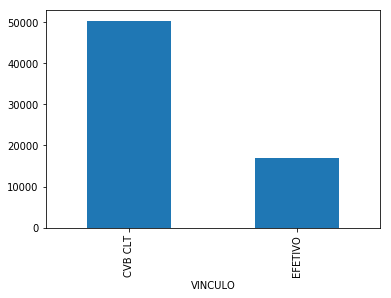

In [16]:
df_Empregados.groupby(['VINCULO'])['VINCULO'].count().sort_values(ascending=False).plot(kind='Bar')

In [17]:
pd.pivot_table(data = df_Empregados, index= ['VINCULO', 'FUNÇÃO'], values=['CPF'], aggfunc='count')

                                         CPF
VINCULO FUNÇÃO                              
CVB CLT AGENTE ADMINISTRATIVO              8
        AGENTE ADMINISTRATIVO            251
        AJUDANTE DE COZINHA               32
        ANALISTA DE SUPORTE                3
        ANALISTA DP                        1
        ANALISTA DP                       30
        ANALISTA FINANCEIRO                1
        ANALISTA FINANCEIRO               32
        ANALISTA RH                        2
        ANALISTA RH                       83
        APOIO                             64
        APOIO                           1977
        APRENDIZ                          22
        APRENDIZ                         736
        ARQUITETO                          1
        ARQUITETO                         32
        ASSESSOR DA DIRECAO                4
        ASSESSOR DA DIRECAO               93
        ASSESSOR DE COMUNICAO              3
        ASSESSOR DE COMUNICAO            122
        AS

### Junta os empregados com o dataframe de sócios das empresas contratadas pelo trauma

In [64]:
df_empregados_vinculos = pd.merge(df_vinculos, df_Empregados, on = 'CPF', how='inner')

In [65]:
df_empregados_vinculos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 25 columns):
CNPJEmpresa                             0 non-null object
Nome / Razão Social (no CNPJ)           0 non-null object
Nome Fantasia (descrição)               0 non-null object
CPF                                     0 non-null object
CNPJ                                    0 non-null object
Nome / Razão Social                     0 non-null object
Qualificação                            0 non-null object
PercentualCapitalSocial                 0 non-null object
DataEntradaSociedade                    0 non-null object
DataExclusãoSociedade                   0 non-null object
ProprietárioEndereço                    0 non-null object
Endereço (logradouro)                   0 non-null object
Bairro                                  0 non-null object
Município                               0 non-null object
SituaçãoCadastral                       0 non-null object
MotivoSituçãoCadastral                  0 

In [70]:
df_Empregados.skew()

Ano     0.13
MAT.     nan
Mes    -0.02
dtype: float64

In [66]:
df_Responsaveis
df_Responsaveis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 2
Data columns (total 6 columns):
NOME             14 non-null object
CPF              14 non-null object
FUNÇÃO           14 non-null object
DATA ADMISSÃO    14 non-null datetime64[ns]
DATA SAÍDA       3 non-null object
VINCULO          14 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 784.0+ bytes


In [19]:
df_Responsaveis

                                 NOME          CPF                          FUNÇÃO DATA ADMISSÃO           DATA SAÍDA  VINCULO
0  EDVAN BENEVIDES DE FREITAS JUNIOR    1026573432  DIRETOR TECNICO                   2011-07-07                  NaN  CVB CLT
1  FERNANDA RIBEIRO FONSECA             7763773707  DIRETOR GERAL                     2014-03-08          31/12/20115  CVB CLT
2  MILTON PACIFICO JOSE ARAUJO         16914058091  SUPERINTENDENTE                   2013-10-01                  NaN  CVB CLT
3  SABRINA GRASIELLE DE CASTRO BERNAR   3523785650  DIRETOR DE ASSISTENCIA            2014-04-01                  NaN  CVB CLT
4  SIDNEY DA SILVA SCHMID              39727360700  DIRETOR ADMINISTRATIVO            2012-01-24                  NaN  CVB CLT
5  SILVIO ANTONIO MOTA GUERRA          82574510704  DIRETOR FINANCEIRO                2011-07-07                  NaN  CVB CLT
0  EDVAN BENEVIDES DE FREITAS JUNIOR    1026573432  DIRETOR TECNICO                   2011-07-07  2016-03-31 00

In [67]:
df_responsaveis_vinculos = pd.merge(df_vinculos, df_Empregados, on = 'CPF', how='inner')

In [68]:
df_responsaveis_vinculos.head()

Empty DataFrame
Columns: [CNPJEmpresa, Nome / Razão Social (no CNPJ), Nome Fantasia (descrição), CPF, CNPJ, Nome / Razão Social, Qualificação, PercentualCapitalSocial, DataEntradaSociedade, DataExclusãoSociedade, ProprietárioEndereço, Endereço (logradouro), Bairro, Município, SituaçãoCadastral, MotivoSituçãoCadastral, PorteEmpresa, Natureza Jurídica do Estabelecimento, UF, Ano, FUNÇÃO, MAT., Mes, NOME, VINCULO]
Index: []

### Exporta o CPF dos empregados/servidores para cruzamentos

In [20]:
cpf_empre = df_Empregados['CPF'].astype(str)
cpf_resp = df_Responsaveis['CPF'].astype(str)
print(cpf_resp.size)
print(cpf_empre.size)


cpf_resp = cpf_resp.drop_duplicates()

cpfs = pd.concat([cpf_empre, cpf_resp])
cpfs.to_csv('cpfs.csv', index=False)

14
67406


In [21]:
cpf_empre.count()

67406

In [22]:
cpf_resp.count()

6

## Carrega os contratos

### Descrição dos dados enviados

- Foi enviada um arquivo excel contendo duas planilhas, nominadas, respectivamente: "Contrato 061-2012" e "contratos 0223-2017" 


### Layout dos dados
As planilhas supracitadas possuem os seguintes campos:EMPRESA,CNPJ DO CREDOR,OBJETO RESUMIDO,INÍCIO,TÉRMINO,VIGENCIA APÓS ADITIVO

In [23]:
df_contratos = carregaContratos()

In [24]:
df_contratos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 22
Data columns (total 13 columns):
CNPJ DO CREDOR           55 non-null object
Demanda                  9 non-null object
EMPRESA                  55 non-null object
INÍCIO                   55 non-null datetime64[ns]
OBJETO RESUMIDO          55 non-null object
TÉRMINO                  55 non-null datetime64[ns]
Unnamed: 10              0 non-null float64
Unnamed: 11              0 non-null float64
Unnamed: 12              1 non-null float64
Unnamed: 8               0 non-null float64
Unnamed: 9               0 non-null float64
VIGENCIA APÓS ADITIVO    55 non-null datetime64[ns]
Valor Mensal(R$)         21 non-null float64
dtypes: datetime64[ns](3), float64(6), object(4)
memory usage: 6.0+ KB


In [25]:
# Renomeia o CNPJ
df_contratos.rename(columns={'CNPJ DO CREDOR': 'CNPJ'}, inplace=True)

In [46]:
# retira a sua máscara para poder fazer os cruzamentos 
retiraMascara(df_contratos)


NameError: name 'df_contratos' is not defined

In [27]:
df_contratos[['EMPRESA','CNPJ', 'INÍCIO', 'TÉRMINO', 'Valor Mensal(R$)']].sort_values(by=['CNPJ'])

                                              EMPRESA            CNPJ     INÍCIO    TÉRMINO  Valor Mensal(R$)
5        EIQUIP SOLUÇÕES EM EQUIPAMENTOS MÉDICOS LTDA  01242766000145 2017-07-01 2019-07-01        223,817.34
6        EIQUIP SOLUÇÕES EM EQUIPAMENTOS MÉDICOS LTDA  01242766000145 2016-07-18 2019-07-18               nan
0                  COPY LINE COMERCIO E SERVIÇOS LTDA  02914690000110 2017-07-01 2018-07-01               nan
16                       RESGATE KM ESPRESSE LTDA ME   03112378000175 2017-02-23 2018-02-23               nan
10                       RESGATE KM ESPRESSE LTDA ME   03112378000175 2017-07-01 2018-07-01         16,000.00
2           LYNN CONSULTORIA DE RECURSOS HUMANOS LTDA  04715048000137 2017-07-01 2018-07-01        555,148.02
14          LYNN CONSULTORIA DE RECURSOS HUMANOS LTDA  04715048000137 2016-11-01 2017-11-01               nan
13          LYNN CONSULTORIA DE RECURSOS HUMANOS LTDA  04715048000137 2015-03-21 2016-03-21               nan
12        

### Exporta o CNPJ dos contratos para cruzamento no DGI

In [28]:
cnpj = df_contratos['CNPJ'].sort_values()

In [29]:
# remove os duplicados
cnpj.drop_duplicates(inplace=True)

In [30]:
cnpj.to_csv('contratos_trauma.csv', index=False)

## Financeiro

In [71]:
# Lê o arquivo Excel todo
arq_excel_financ = pd.ExcelFile(os.path.join(pasta_dados, nome_arq_financeiro))
# loop nas planilhas do arquivo
contas = []
for planilha in arq_excel_financ.sheet_names:
## begin-for    
   df_planilha = arq_excel_financ.parse(planilha)
   df_planilha['Ano'] = planilha
   contas.append(df_planilha)

## end-for        
df_Financeiro = pd.concat(contas)    

In [72]:
df_Financeiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12702 entries, 0 to 4426
Data columns (total 10 columns):
Ano              12702 non-null object
CNPJ             8262 non-null object
DATA             12701 non-null object
DISCRIMINAÇÃO    12696 non-null object
ENTRADA          495 non-null float64
FORNECEDOR       12702 non-null object
NF               8248 non-null object
NOTA FISCAL      2749 non-null object
SALDO            4427 non-null object
SAÍDA            12702 non-null float64
dtypes: float64(2), object(8)
memory usage: 1.1+ MB


In [73]:
df_Financeiro.set_index('FORNECEDOR', inplace=True)

In [74]:
df_Financeiro.rename(columns={'DATA ':'DATA'}, inplace=True)

In [75]:
df_Financeiro[['CNPJ', 'ENTRADA', 'SAÍDA']]

                                                                  CNPJ      ENTRADA        SAÍDA
FORNECEDOR                                                                                      
Saldo de Dezembro 2014                                               -         0.00         0.00
Devolução                                                9125576000150    49,694.38         0.00
Pronto Socorro Cardiológico - HTOP - Prontocor -         9125576000150          nan    49,694.38
Hidraudiesel Serviços Hidraúlicos LTDA                   6076888000122          nan     2,946.50
Andrezza Quirino Ramalho de Moura                       060.627.314-03          nan     3,495.64
Ana Elizabeth B. Rodrigues Dantas                       144.247.544-72          nan       888.93
Classe A Representações Ltda - Me                        4005545000141          nan   143,732.07
Folha de Pagamento                                       8778268000160          nan    18,000.00
Companhia De Água E Esgotos Da

### Exclui a linha denominada de "Total de Saídas" para evitar erro nos valores

In [76]:
df_Financeiro.drop('TOTAL DE SAÍDAS', inplace=True)

In [77]:
pivot_financ_forn = pd.pivot_table(data = df_Financeiro, index= ['FORNECEDOR'], values=['SAÍDA'], aggfunc='sum')

In [78]:
pivot_financ_forn.sort_values(by='SAÍDA', ascending=False)

                                                           SAÍDA
FORNECEDOR                                                      
Folha de Pagamento                                 97,263,908.30
BB renda fixa                                      63,993,904.06
Folha de pagamento                                 21,460,365.21
Cooperativa Neuroc Neurol Cir Vasculares           20,708,721.02
Coort - Pb Coop Ortop Traumatologia Pb             19,774,576.13
Gastronomia Nordeste Com Serv Alimentos            17,861,052.02
Cooperativa Dos Cirurgiões Da Paraíba              12,760,563.80
Lynn Consultoria De Recursos Humanos Ltd           11,688,987.16
FGTS                                               11,357,192.36
INSS Empregados                                     9,110,667.67
Imobras Empreendimentos Imobiliários Ltd            9,070,120.72
Folha de Férias                                     8,391,853.99
Engemed - Engenharia E Consultoria Ltda             6,911,810.43
Energisa Paraíba - Distri

### Exporta para o Excel a lista de pagamentos feitos

In [39]:
pivot_financ_forn.to_excel('pagamentos_fornecedor.xlsx')

### Exporta o dataset completo

In [58]:
df_Financeiro.to_excel('pagamentos.xlsx')

### Os maiores destinatários de recursos do Trauma (2015-2017)

In [40]:
pag_acima_milhao = pivot_financ_forn[pivot_financ_forn['SAÍDA'] > 5000000].sort_values(by='SAÍDA', ascending=False)

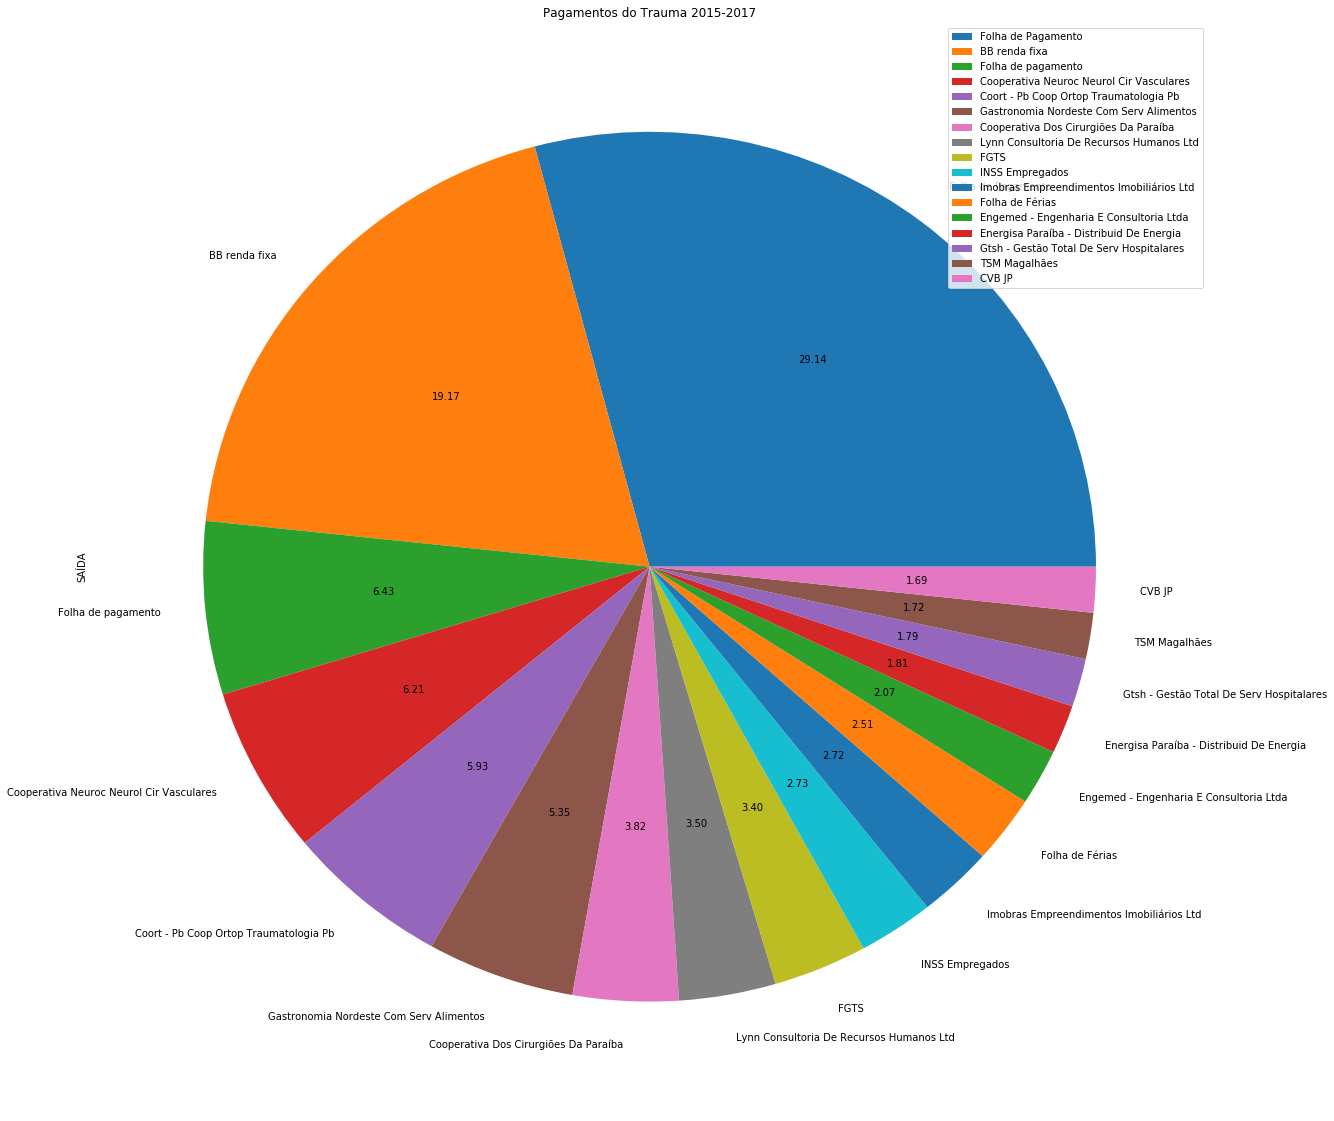

In [41]:
pag_acima_milhao.plot(kind='pie', y='SAÍDA', figsize=(20, 20), grid=True, legend=True, autopct='%.2f', 
                      title='Pagamentos do Trauma 2015-2017')

### Análise da variável "Saída" que representa os valores pagos pelo Trauma

In [42]:
df_Financeiro['SAÍDA'].describe()

count       12,701.00
mean        36,736.29
std        266,289.80
min              0.00
25%             41.53
50%          1,710.67
75%          9,385.00
max     12,706,300.00
Name: SAÍDA, dtype: float64

### Comentários
- 25% dos 12.701 pagamentos estão abaixo de R$ 42 (1º Quartil)

- 50% abaixo de R$ 1.800,00 (2º Quartil)

### Agrupa e totaliza os valores do primeiro quartil (os 25% menores pagamentos)

In [43]:
df_Financeiro[df_Financeiro['SAÍDA'] < 42]['SAÍDA'].groupby('FORNECEDOR').sum().sort_values(ascending=False)

FORNECEDOR
Tarifa DOC/TED Eletrônico.                             21,275.52
Tarifa Pag Salário Crédito em Conta                       401.58
Sind Enfermeiros no Estado da Paraíba                     158.90
Folha de Pagamento                                        146.96
Folha de pagamento                                        138.78
IRRF                                                      136.25
Tarifa Lib/Ant Float Pag Salário                           86.09
Bloqueio Judicial                                          75.35
PIS/COFINS/CSLL                                            58.42
Tarifa Pacote de Serviços                                  55.50
Pagamento Trabalhista                                      44.04
Shopping da Criança LTDA - ME                              40.00
Alexsandra Lima da Silva                                   38.33
Josivando Alexandre de Oliveira                            36.00
Laboratório de Patologia Clínica S/S Limitada Hemato       31.70
Rodrigues Albu

### Agrupa e totaliza os valores entre o primeiro e o segundo quartil

In [44]:
df_Financeiro[(df_Financeiro['SAÍDA'] > 42) & (df_Financeiro['SAÍDA'] < 1710)]['SAÍDA'].groupby('FORNECEDOR').sum().sort_values(ascending=False)

FORNECEDOR
Folha de Pagamento                                                                      567,241.44
Folha de pagamento                                                                       89,287.05
Tarifa Pag Salário Crédito em Conta                                                      54,017.05
Tribunal Regional do Trabalho                                                            52,143.55
Tarifa Lib/Ant Float Pag Salário                                                         49,130.17
Energisa Paraíba - Distribuid De Energia                                                 47,750.07
FGTS Rescisório                                                                          40,484.06
Epimed Solutions Tecnologia Info Médicas                                                 39,969.33
Unimed João Pessoa Coop Trab Médico                                                      29,185.74
Oi Móvel S.A.                                                                            27,353.00

### Agrupa e totaliza os valores do terceiro quartil (75% maiores pagamentos)

In [45]:
df_Financeiro[df_Financeiro['SAÍDA'] > 9385]['SAÍDA'].groupby('FORNECEDOR').sum().sort_values(ascending=False)

FORNECEDOR
Folha de Pagamento                                                                          94,896,292.46
BB renda fixa                                                                               63,984,904.06
Folha de pagamento                                                                          21,020,205.24
Cooperativa Neuroc Neurol Cir Vasculares                                                    20,703,686.26
Coort - Pb Coop Ortop Traumatologia Pb                                                      19,758,162.88
Gastronomia Nordeste Com Serv Alimentos                                                     17,861,052.02
Cooperativa Dos Cirurgiões Da Paraíba                                                       12,753,729.61
Lynn Consultoria De Recursos Humanos Ltd                                                    11,680,958.89
FGTS                                                                                        11,341,861.75
INSS Empregados                    

In [57]:
df_Financeiro[df_Financeiro['SAÍDA'] > 9385][['SAÍDA', 'DATA']].sort_values(by=['DATA'])

                                                           SAÍDA                 DATA
FORNECEDOR                                                                           
Pronto Socorro Cardiológico - HTOP - Prontocor -       49,694.38  2015-01-02 00:00:00
Classe A Representações Ltda - Me                     143,732.07  2015-01-02 00:00:00
Folha de Pagamento                                     18,000.00  2015-01-02 00:00:00
Rofer Engenharia LTDA                                  38,500.00  2015-01-06 00:00:00
Pronto Socorro Cardiológico - HTOP - Prontocor -       49,694.38  2015-01-08 00:00:00
Excellence Rh Serviços - Eireli                       100,000.00  2015-01-09 00:00:00
Dias E Costa Const. Desenvolvimento Ltda               50,529.50  2015-01-09 00:00:00
Rd Tecnologia Comércio E Serviços Ltda                 31,500.00  2015-01-09 00:00:00
Imobras Empreendimentos Imobiliários Ltd               50,000.00  2015-01-30 00:00:00
Coort - Pb Coop Ortop Traumatologia Pb                

### <span style='color:red'> Leandro Torres Andrade da Nóbrega - Valor pago  R$ 3.450.358,45 </span>                                                        
#### Valor muito alto pago a uma pessoa física


### Pivot Table para vizualizar os pagamentos feitos a fornecedores por ano

In [48]:
pivot_financ_forn_ano = pd.pivot_table(data = df_Financeiro, 
                                       index= ['FORNECEDOR'], 
                                       columns=['Ano'],
                                       values=['SAÍDA'],                                
                                       aggfunc='sum')

In [49]:
pivot_financ_forn_ano

                                                          SAÍDA                           
Ano                                                        2015         2016          2017
FORNECEDOR                                                                                
A R Rodrigues de Oliveira                                   nan          nan      8,742.00
A União Superintendência de Imprensa e Editora         2,840.00     3,480.00           nan
A União Superitendência de Imprensa e Editora            500.00       300.00           nan
ABS Frio Serviços Ltda - ME                                 nan    77,900.00           nan
AETC - Ass Emp Transp Coletivos Urbanos João Pe...    52,214.68          nan           nan
AETC - Ass. Emp. Transp. Colet. Urb. JP               38,257.07          nan           nan
Abril Comunicações                                    58,665.58          nan           nan
Acionador Médico Comércio Ltda - Epp                  42,326.00          nan           nan

### Ordena o dataframe do pivot pelos maiores valores pagos

In [50]:
pivot_financ_forn_ano.sort_values(by=pivot_financ_forn_ano.columns[0], ascending=False)

                                                           SAÍDA                            
Ano                                                         2015          2016          2017
FORNECEDOR                                                                                  
Folha de Pagamento                                 39,021,258.04 41,619,206.40 16,623,443.86
Coort - Pb Coop Ortop Traumatologia Pb              7,124,549.75  8,051,685.55  4,598,340.83
Cooperativa Neuroc Neurol Cir Vasculares            6,265,603.77  7,142,224.43  7,300,892.82
Cooperativa Dos Cirurgiões Da Paraíba               4,220,465.01  5,356,405.01  3,183,693.78
FGTS                                                3,334,335.85  3,806,829.80  4,216,026.71
Imobras Empreendimentos Imobiliários Ltd            2,752,906.37  3,572,753.25  2,744,461.10
Lynn Consultoria De Recursos Humanos Ltd            2,224,109.40  4,249,128.08  5,215,749.68
Folha de Férias                                     2,148,313.45  3,03

### Exporta a listagem de pagamentos por ano

In [51]:
pivot_financ_forn_ano.to_excel('pagamentos_fornecedor_ano.xlsx')

### Gastos anuais do Trauma

In [52]:
gastos_ano = df_Financeiro.groupby('Ano')['SAÍDA'].sum()

In [53]:
gastos_ano

Ano
2015   117,149,739.46
2016   142,149,006.11
2017   207,288,813.64
Name: SAÍDA, dtype: float64

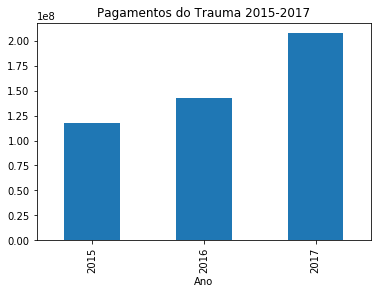

In [54]:
gastos_ano.plot(kind='bar', legend=False,title='Pagamentos do Trauma 2015-2017',  )

### Análise das Entradas de Recursos

In [55]:
df_Financeiro['ENTRADA'].groupby('FORNECEDOR').sum().sort_values(ascending=False)

FORNECEDOR
Repasse da Sec. Estado da Saúde                                                             353,977,865.79
BB renda fixa                                                                                63,749,754.84
Repasse da Secretaria de Estado da Saúde                                                     30,391,193.86
CVB JP                                                                                        5,647,886.71
Devolução                                                                                     2,103,697.91
TED Crédito em Conta - MATRIZ                                                                   480,009.59
TED Crédito em Conta                                                                            337,704.07
Desbloqueio Judicial                                                                            316,816.13
CVB RJ                                                                                          315,974.75
Desbloqueio Judicial\nTrib

### Filtra para termos apenas valores de entrada válido

In [56]:
df_entradas = df_Financeiro[df_Financeiro['ENTRADA'].notnull()]

In [57]:
pivot_financ_entradas_ano = pd.pivot_table(data = df_entradas, 
                                           index= ['FORNECEDOR'], 
                                           columns=['Ano'],
                                           values=['ENTRADA'],                                
                                           aggfunc='sum')

### exporta a pivot table com os valores de entrada

In [58]:
pivot_financ_entradas_ano.sort_values(by=pivot_financ_entradas_ano.columns[2], ascending=False).to_excel('entradas_ano.xlsx')

In [59]:
pivot_financ_entradas = pd.pivot_table(data = df_entradas, 
                                           index= ['FORNECEDOR'], 
                                           columns=['Ano'],
                                           values=['ENTRADA'],                                
                                           aggfunc='sum')

In [60]:
pivot_financ_entradas.sort_values(by=pivot_financ_entradas.columns[2], ascending=False)

                                                          ENTRADA                              
Ano                                                          2015           2016           2017
FORNECEDOR                                                                                     
Repasse da Sec. Estado da Saúde                    106,167,278.20 110,471,208.76 137,339,378.83
BB renda fixa                                                 nan            nan  63,749,754.84
CVB JP                                                        nan            nan   5,647,886.71
Devolução                                              692,921.07     910,591.03     500,185.81
TED Crédito em Conta                                          nan            nan     337,704.07
CVB RJ                                                        nan            nan     315,974.75
Desbloqueio Judicial\nTribunal Regional do Trab...            nan            nan      78,561.61
TED Crédito em Conta - MATRIZ           

## Dispensação de insumos aos pacientes

In [8]:
# lista de dataframes
frames_dispens = []
## loop nas planilhas enviadas 
for arq_dispensacao in os.listdir(pasta_dispensacao):
## begin-for    
    # trata jan/2015 de forma diferente
    if arq_dispensacao.find('012015') >= 0:
       print('Jan de2015...pulando, por enquanto')
       continue
    else:
        print('Lendo...' + arq_dispensacao)
        # lê o arquivo atual
        df = pd.read_excel(os.path.join(pasta_dispensacao, arq_dispensacao), converters= {'PRODUTOCODIGOAUXILIAR': int})
        frames_dispens.append(df)
        
## end-for
df_dispensacao = pd.concat(frames_dispens)

    

Jan de2015...pulando, por enquanto
Lendo...012016.xlsx
Lendo...012017.xlsx
Lendo...022015.xlsx
Lendo...022016.xlsx
Lendo...022017.xlsx
Lendo...032015.xlsx
Lendo...032016.xlsx
Lendo...032017.xlsx
Lendo...042015.xlsx
Lendo...042016.xlsx
Lendo...042017.xlsx
Lendo...052015.xlsx
Lendo...052016.xlsx
Lendo...052017.xlsx
Lendo...062015.xlsx
Lendo...062016.xlsx
Lendo...062017.xlsx
Lendo...072015.xlsx
Lendo...072016.xlsx
Lendo...072017.xlsx
Lendo...082015.xlsx
Lendo...082016.xlsx
Lendo...082017.xlsx
Lendo...092015.xlsx
Lendo...092016.xlsx
Lendo...092017.xlsx
Lendo...102015.xlsx
Lendo...102016.xlsx
Lendo...102017.xlsx
Lendo...112015.xlsx
Lendo...112016.xlsx
Lendo...112017.xlsx
Lendo...122015.xlsx
Lendo...122016.xlsx
Lendo...122017.xlsx


In [9]:
df_dispensacao.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358494 entries, 0 to 52290
Data columns (total 13 columns):
ID                       1358494 non-null int64
SECAOREQUISITADAID       1358494 non-null int64
SECAOREQUISITADANOME     1358494 non-null object
PRODUTOID                1358494 non-null int64
PRODUTONOME              1358494 non-null object
PRODUTOLOTE              1358494 non-null object
DATAVALIDADE             1358494 non-null object
QUANTIDADE               1358494 non-null int64
VALOR                    1358388 non-null float64
TIPOMOVIMENTO            1358494 non-null object
DESTINO                  1358492 non-null object
DATA                     1358494 non-null datetime64[ns]
PRODUTOCODIGOAUXILIAR    1350855 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(7)
memory usage: 145.1+ MB


### Campo calculado para conter :R$ x Quant.

In [10]:
df_dispensacao['VALOR_TOTAL'] = df_dispensacao['VALOR'] * df_dispensacao['QUANTIDADE']

In [11]:
df_dispensacao['VALOR_TOTAL'].describe()

count   1,358,388.00
mean           13.22
std            55.37
min             0.00
25%             1.00
50%             3.24
75%            10.90
max         9,600.00
Name: VALOR_TOTAL, dtype: float64

### Seta a data como nosso índice
#### para permitir que sejam feitos resamplings dos dados para agrupamento

In [12]:
df_dispensacao.index = df_dispensacao['DATA']

In [13]:
df_dispensacao['2016'].head()

                          ID  SECAOREQUISITADAID            SECAOREQUISITADANOME  PRODUTOID                                        PRODUTONOME PRODUTOLOTE         DATAVALIDADE  QUANTIDADE  VALOR                     TIPOMOVIMENTO                                   DESTINO                DATA PRODUTOCODIGOAUXILIAR  VALOR_TOTAL
DATA                                                                                                                                                                                                                                                                                                                                 
2016-01-01 00:08:59  2724328                 308  FARMÁCIA SATÉLITE - EMERGÊNCIA      22739  IMUNOGLOBULINA ANTITETANICA 250UI/ML INJETAVEL...   31945831B  2016-08-30 00:00:00           1  22.27  PRODUTO DISPENSADO PARA PACIENTE     890367 - IRISNALDO LEAL DO NASCIMENTO 2016-01-01 00:08:59                 22739        22.27
2016-01-01 00:09:34  2

In [14]:
df_dispensacao[['ID', 'PRODUTONOME', 'QUANTIDADE', 'VALOR', 'PRODUTOCODIGOAUXILIAR']].head(200)

                          ID                                        PRODUTONOME  QUANTIDADE  VALOR PRODUTOCODIGOAUXILIAR
DATA                                                                                                                    
2016-01-01 00:08:59  2724328  IMUNOGLOBULINA ANTITETANICA 250UI/ML INJETAVEL...           1  22.27                 22739
2016-01-01 00:09:34  2724329           TRAMADOL 50MG /ML INJETAVEL (AMPOLA 2ML)           5   1.13                  1670
2016-01-01 00:10:04  2724330          FENITOINA 50MG /ML INJETAVEL (AMPOLA 5ML)           3   2.51                  1636
2016-01-01 00:11:04  2724331          FENITOINA 50MG /ML INJETAVEL (AMPOLA 5ML)           3   2.51                  1636
2016-01-01 00:11:54  2724332          FENITOINA 50MG /ML INJETAVEL (AMPOLA 5ML)           5   2.51                  1636
2016-01-01 00:12:57  2724333          FENITOINA 50MG /ML INJETAVEL (AMPOLA 5ML)           5   2.51                  1636
2016-01-01 00:13:31  2724334    

In [172]:
df_dispensacao['DATA'].describe()

count                 1358494
unique                1338872
top       2015-04-28 12:12:46
freq                       10
first     2015-02-01 00:26:09
last      2017-12-28 23:49:33
Name: DATA, dtype: object

## Quantidades dispensadas

In [15]:
df_dispensacao['QUANTIDADE'].describe()

count   1,358,494.00
mean            3.41
std            12.76
min             1.00
25%             1.00
50%             2.00
75%             4.00
max         4,800.00
Name: QUANTIDADE, dtype: float64

### Quantidades e produtos

In [104]:
df_dispensacao[df_dispensacao['QUANTIDADE'] > 1000][['PRODUTONOME', 'QUANTIDADE', 'VALOR_TOTAL']].sort_values(by='QUANTIDADE', ascending=False)

                                                           PRODUTONOME  QUANTIDADE  VALOR_TOTAL
DATA                                                                                           
2015-12-25 09:02:13               LUVA DE PROCEDIMENTO COM TALCO MEDIA        4800       864.00
2016-01-03 16:36:06               LUVA DE PROCEDIMENTO COM TALCO MEDIA        2800       504.00
2015-08-31 18:06:35               LUVA DE PROCEDIMENTO COM TALCO MEDIA        2700       378.00
2015-08-07 17:14:04               LUVA DE PROCEDIMENTO COM TALCO MEDIA        2600       364.00
2016-01-23 14:07:40               LUVA DE PROCEDIMENTO COM TALCO MEDIA        2500       450.00
2016-05-05 06:48:10              LUVA DE PROCEDIMENTO COM TALCO GRANDE        2000       500.00
2017-05-23 08:56:57               LUVA DE PROCEDIMENTO COM TALCO MEDIA        2000       340.00
2015-07-15 19:01:48               LUVA DE PROCEDIMENTO COM TALCO MEDIA        2000       280.00
2016-01-05 16:54:25               LUVA D

In [174]:
df_dispensacao.groupby('PRODUTONOME')[['QUANTIDADE', 'VALOR_TOTAL']].sum().sort_values(by='QUANTIDADE',ascending=False)

                                                    QUANTIDADE  VALOR_TOTAL
PRODUTONOME                                                                
DIPIRONA 500MG/ML INJETAVEL (AMPOLA 2ML)                601039   277,739.74
LUVA DE PROCEDIMENTO COM TALCO MEDIA                    218553    37,710.18
FENTANILA 0,05 MG/ML INJETAVEL (FRASCO- AMPOLA ...      145032   379,903.34
CEFALOTINA 1G INJETAVEL (FRASCO-AMPOLA)                 144019   528,837.03
MEROPENEM 500MG INJETAVEL (FRASCO-AMPOLA)               139721 1,230,899.02
DIPIRONA 500MG COMPRIMIDO                               132085    15,302.31
TRAMADOL 50MG /ML INJETAVEL (AMPOLA 2ML)                125710   128,406.48
MIDAZOLAM 50MG/10ML INJETAVEL (AMPOLA 10ML)             119928   326,336.03
OMEPRAZOL 20MG  CAPSULA                                 116207     8,833.05
NOREPINEFRINA, HEMITARTARATO 2MG/ML 4ML - ALTO ...      103304   381,456.63
AGUA DESTILADA (AMPOLA 10ML) ESTERIL                     85457    13,665.96
FENITOINA 50

### Quantidades por produto por paciente

### Analisa as dispensações de Dipirona

In [175]:
df_dispensacao[df_dispensacao['PRODUTONOME'].str.match('DIPIRONA')][['DESTINO', 'QUANTIDADE', 'PRODUTONOME']].sort_values(by=['QUANTIDADE', 'DESTINO'], ascending=False).to_excel('dipirona.xlsx')

In [139]:
df_dispensacao[df_dispensacao['DESTINO'].str.contains('PAULO GABRIEL', na=False)][['PRODUTONOME', 'QUANTIDADE', 'PRODUTONOME']]

                                                           PRODUTONOME  QUANTIDADE                                        PRODUTONOME
DATA                                                                                                                                 
2015-03-08 11:36:40            DIPIRONA 500MG/ML SOLUCAO (FRASCO 10ML)           5            DIPIRONA 500MG/ML SOLUCAO (FRASCO 10ML)
2015-03-08 11:37:12           DIPIRONA 500MG/ML INJETAVEL (AMPOLA 2ML)        2000           DIPIRONA 500MG/ML INJETAVEL (AMPOLA 2ML)
2015-03-08 11:37:24  TENOXICAM 40MG INJETAVEL (FRASCO/AMPOLA) - NAO...           1  TENOXICAM 40MG INJETAVEL (FRASCO/AMPOLA) - NAO...
2015-03-08 11:37:33          CEFTRIAXONA SODICA 500MG INJETAVEL ( IM )           1          CEFTRIAXONA SODICA 500MG INJETAVEL ( IM )
2015-03-08 11:58:44   METRONIDAZOL 500MG 0,5% INJETAVEL (FRASCO 100ML)           1   METRONIDAZOL 500MG 0,5% INJETAVEL (FRASCO 100ML)
2015-03-18 11:17:34  CURATIVO ANTIBACTERIANO COM PRATA COMPOST

### Produtos de maior valor

In [109]:
df_dispensacao['VALOR'].describe()

count   1,358,388.00
mean            6.23
std            35.96
min             0.00
25%             0.43
50%             1.18
75%             4.65
max         5,200.00
Name: VALOR, dtype: float64

In [111]:
df_dispensacao[df_dispensacao['VALOR'] > 4000][['PRODUTONOME', 'VALOR']].sort_values(by='VALOR', ascending=False)

                                                           PRODUTONOME    VALOR
DATA                                                                           
2017-08-29 17:25:57             FILTRO DE VEIA CAVA FEMURAL OU JUGULAR 5,200.00
2017-10-05 18:11:42             FILTRO DE VEIA CAVA FEMURAL OU JUGULAR 5,200.00
2017-11-09 17:37:23             FILTRO DE VEIA CAVA FEMURAL OU JUGULAR 5,200.00
2017-12-26 17:41:21             FILTRO DE VEIA CAVA FEMURAL OU JUGULAR 5,200.00
2017-11-28 18:36:40                    FILTRO DE VEIA CAVA G2X FEMURAL 5,000.00
2017-01-18 14:44:00                    FILTRO DE VEIA CAVA G2X FEMURAL 4,900.00
2017-02-21 16:25:37             FILTRO DE VEIA CAVA FEMURAL OU JUGULAR 4,900.00
2017-03-21 14:17:34             FILTRO DE VEIA CAVA FEMURAL OU JUGULAR 4,900.00
2017-04-04 15:59:28             FILTRO DE VEIA CAVA FEMURAL OU JUGULAR 4,900.00
2016-06-09 15:24:46                    FILTRO DE VEIA CAVA G2X FEMURAL 4,900.00
2016-06-09 15:24:54                    F

### Valores de produtos dispensados por mês

In [105]:
df_dispensacao['VALOR_TOTAL'].resample('M').sum()

DATA
2015-02-28   272,363.92
2015-03-31   374,810.47
2015-04-30   416,294.30
2015-05-31   489,597.60
2015-06-30   440,505.70
2015-07-31   547,865.04
2015-08-31   549,600.21
2015-09-30   631,768.82
2015-10-31   599,925.99
2015-11-30   594,928.55
2015-12-31   573,727.66
2016-01-31   475,485.66
2016-02-29   533,498.49
2016-03-31   569,189.92
2016-04-30   520,631.76
2016-05-31   493,266.52
2016-06-30   476,506.42
2016-07-31   530,777.80
2016-08-31   589,011.31
2016-09-30   478,241.77
2016-10-31   489,767.65
2016-11-30   487,872.97
2016-12-31   467,654.16
2017-01-31   451,844.39
2017-02-28   453,227.17
2017-03-31   529,455.29
2017-04-30   464,683.26
2017-05-31   585,421.43
2017-06-30   525,371.65
2017-07-31   559,410.25
2017-08-31   566,355.26
2017-09-30   574,975.26
2017-10-31   559,643.55
2017-11-30   525,885.80
2017-12-31   562,762.36
Freq: M, Name: VALOR_TOTAL, dtype: float64

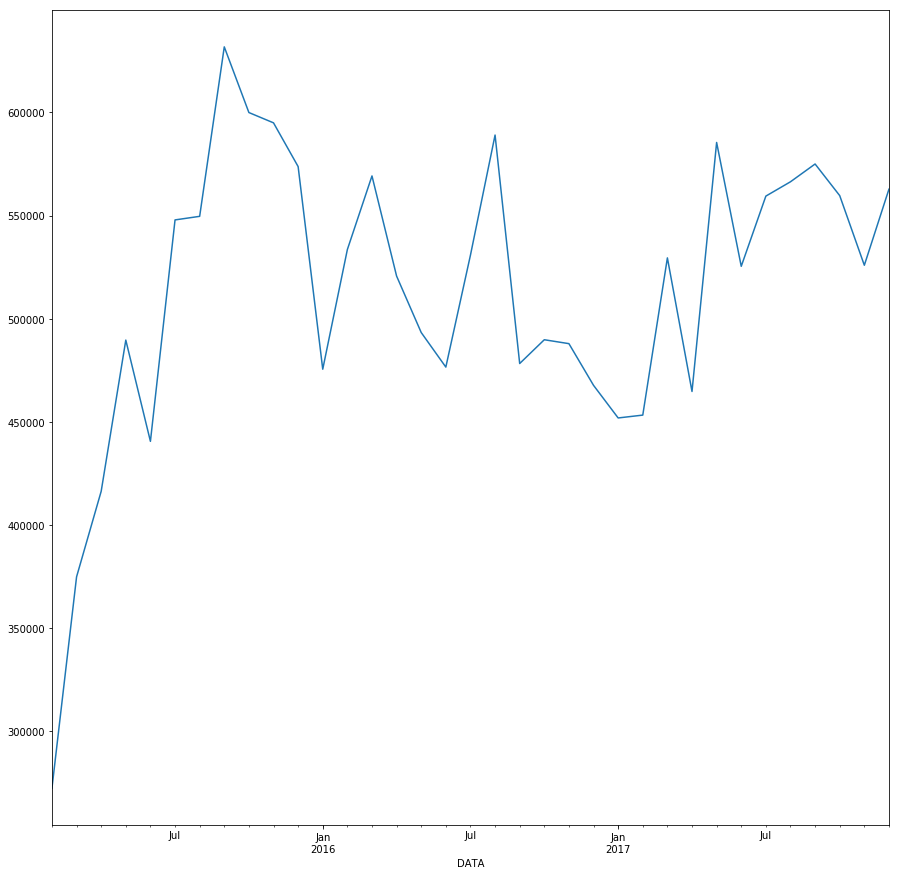

In [106]:
df_dispensacao['VALOR_TOTAL'].resample('M').sum().plot(figsize =(15,15))

### Gráfico de dispensação diária 2015-2017

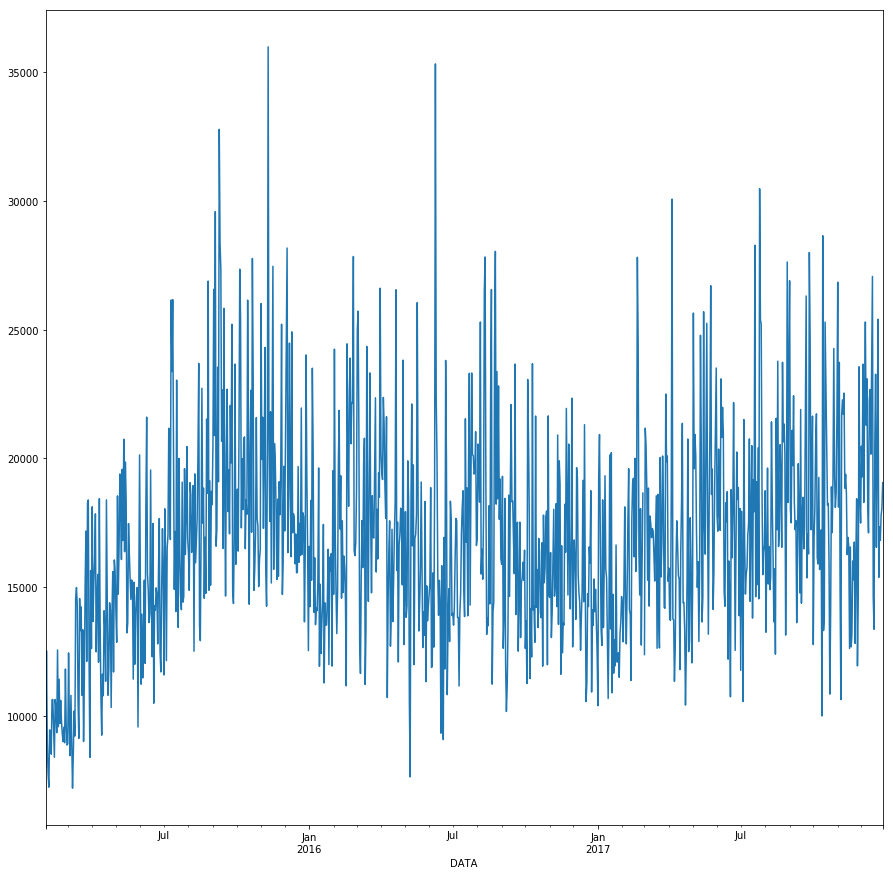

In [114]:
df_dispensacao['VALOR_TOTAL'].resample('D').sum().plot(kind='line', figsize=(15,15))

### Dispensação por Produto/Quantidade

In [22]:
df_dispensacao_por_prod = df_dispensacao.groupby('PRODUTONOME')['QUANTIDADE'].sum().sort_values(ascending=False)

In [23]:
df_dispensacao_por_prod

PRODUTONOME
DIPIRONA 500MG/ML INJETAVEL (AMPOLA 2ML)                                                                                                                                               601039
LUVA DE PROCEDIMENTO COM TALCO MEDIA                                                                                                                                                   218553
FENTANILA 0,05 MG/ML INJETAVEL (FRASCO- AMPOLA 10ML)                                                                                                                                   145032
CEFALOTINA 1G INJETAVEL (FRASCO-AMPOLA)                                                                                                                                                144019
MEROPENEM 500MG INJETAVEL (FRASCO-AMPOLA)                                                                                                                                              139721
DIPIRONA 500MG COMPRIMIDO             

In [24]:
df_dispensacao_por_prod.to_excel('dispensacao_por_produto.xlsx')

### Dispensação por paciente e produto

In [30]:
df_disp_pac_prod = df_dispensacao.groupby(['DESTINO', 'PRODUTONOME'])['QUANTIDADE'].sum().sort_values(ascending=False)

In [32]:
df_disp_pac_prod.to_excel('dispens_paciente_produto.xlsx')

### Pivot table das dispensações de produtos e pacientes

In [41]:
pivot_disp_produto = pd.pivot_table(data=df_dispensacao, index=['DESTINO', 'PRODUTONOME'], values=['QUANTIDADE'], aggfunc='sum')

In [42]:
pivot_disp_produto

                                                                                                   QUANTIDADE
DESTINO                                        PRODUTONOME                                                   
1000008 - JOSE FERNANDES FIRME                 CEFALOTINA 1G INJETAVEL (FRASCO-AMPOLA)                     20
                                               CEFTRIAXONA 1000MG IV                                       10
                                               CLONAZEPAM 0,5MG COMPRIMIDO                                  3
                                               CODEINA + PARACETAMOL (30MG+500MG) COMPRIMIDO                8
                                               DIPIRONA 500MG COMPRIMIDO                                   88
                                               DIPIRONA 500MG/ML INJETAVEL (AMPOLA 2ML)                    20
                                               ENOXAPARINA 20 MG SUBCUTANEA INJETAVEL (SERINGA...          40
          

In [43]:
pivot_disp_produto.to_excel('dispens_paciente_produto.xlsx')

In [108]:
df_dispensacao.groupby('PRODUTONOME')['VALOR_TOTAL'].mean().sort_values(ascending=False)

PRODUTONOME
CARGA PARA GRAMPEADOR ENDO GIA UNIVERSAL 60MM COR ROXA                                                                                                                                9,600.00
FILTRO DE VEIA CAVA FEMURAL OU JUGULAR                                                                                                                                                5,071.43
FILTRO DE VEIA CAVA G2X FEMURAL                                                                                                                                                       4,646.00
PROTESE TRAQUEOBRONQUIAL DE SILICONE ORTESE DE DUMONT Nº13                                                                                                                            4,165.00
CATETER MICROSSENSOR DE PRESSAO INTRACRANIANA INTRAPARENQUIMAL (PIC)                                                                                                                  3,637.93
PLACA BLOQUEADA LPS PROXIMAL UMER

### Valores gastos por ano

In [117]:
df_dispensacao['VALOR_TOTAL'].resample('A').sum()

DATA
2015-12-31   5,491,388.26
2016-12-31   6,111,904.43
2017-12-31   6,359,035.67
Freq: A-DEC, Name: VALOR_TOTAL, dtype: float64

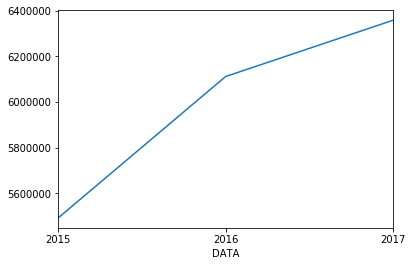

In [118]:
df_dispensacao['VALOR_TOTAL'].resample('A').sum().plot()

In [149]:
a = df_dispensacao[['QUANTIDADE', 'PRODUTONOME']].resample('M').sum()

In [151]:
a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35 entries, 2015-02-28 to 2017-12-31
Freq: M
Data columns (total 1 columns):
QUANTIDADE    35 non-null int64
dtypes: int64(1)
memory usage: 560.0 bytes


### Dispensação por paciente (soma)

In [119]:
df_dispensacao.groupby('DESTINO')['VALOR_TOTAL'].sum().sort_values(ascending=False)

DESTINO
957480 - RAQUEL ELIZAMA SANTANA DE ANDRADE             60,812.67
883334 - EVERALDO FELIX DOS SANTOS                     56,308.42
848985 - GLERISTON CORDEIRO DE VASCONCELOS             52,666.83
951367 - SELMA TRAJANO PEREIRA                         52,183.52
835861 - TEREZINHA DA SILVA ALMEIDA                    51,016.89
875882 - ELISANGELA DA SILVA NASCIMENTO                43,177.91
935395 - PEDRO FRANCISCO FERREIRA JUNIOR               43,029.40
841137 - RENATA QUEZIA ALVES PEREIRA                   38,945.42
832640 - JAIME DE AZEVEDO ALVES                        38,394.69
990850 - MARCULINO PEREIRA RAMALHO                     37,273.06
829817 - RENATO ROMERO HENRIQUES                       35,209.95
889775 - DANIEL REZENDE DA SILVA                       34,854.52
872998 - MARIA DAS NEVES VICENTE DA SILVA              33,582.72
903100 - MARIA BERNADETE PEREIRA DE SOUSA              32,146.18
867931 - FRANCISCO ALEXANDRE DE FIGUEIREDO             31,593.22
981740 - MANOEL G

In [20]:
df_dispensacao.groupby('DESTINO')['QUANTIDADE'].sum().sort_values(ascending=False)

DESTINO
852511 - JOSE ANDRE SALES                                10969
908560 - ANTONIO MARCOS SALES                            10619
883334 - EVERALDO FELIX DOS SANTOS                       10221
867931 - FRANCISCO ALEXANDRE DE FIGUEIREDO                9578
835861 - TEREZINHA DA SILVA ALMEIDA                       8956
957480 - RAQUEL ELIZAMA SANTANA DE ANDRADE                8794
861960 - MARCELO FELIX DA SILVA                           8607
901493 - WELLINGTON DA SILVA PEREIRA                      8452
951367 - SELMA TRAJANO PEREIRA                            8205
887994 - RICARDO VIEIRA DA COSTA                          8038
875882 - ELISANGELA DA SILVA NASCIMENTO                   7914
889775 - DANIEL REZENDE DA SILVA                          7713
981740 - MANOEL GETULIO DA ROCHA                          7486
850854 - SEVERINO MARQUES                                 7463
848985 - GLERISTON CORDEIRO DE VASCONCELOS                7280
841137 - RENATA QUEZIA ALVES PEREIRA           

### Dispensação por paciente (Média)

In [120]:
df_dispensacao.groupby('DESTINO')['VALOR_TOTAL'].mean().sort_values(ascending=False)

DESTINO
1025355 - LUIZ MIGUEL DA SILVA SOUZA                    4,200.00
823732 - FLAVIANE DE LIMA GARCIA DANTAS                 2,990.00
1038430 - SIDNEY RANIERE PEREIRA RODRIGUES              1,999.60
897676 - WENDEL FERREIRA DE LIMA                        1,787.76
856818 - ELIZABETH PIMENTEL DE LIMA                     1,500.00
929272 - YONE KATE DOS SANTOS                           1,330.00
929437 - JOSE NETO TOSCANO DE BRITO                     1,330.00
951657 - CRISTIANE DE ALBUQUERQUE SILVA                 1,329.80
894654 - JOAO VITOR DOS SANTOS XAVIER                   1,318.80
846936 - ERYLEIDE PORFIRIO FERREIRA                     1,304.00
868879 - VICTOR SILAS MARQUES SOARES                    1,300.00
998006 - VAMBERGE BARBOSA DA SILVA                      1,266.10
980701 - CRISTIANO CRUZ SOARES                          1,198.20
1011632 - ANTONIO ALEXANDRE DA SILVA                    1,186.05
1025955 - IGOR GABRIEL SOUSA SILVA                      1,050.00
871592 - EDUARDO 

## Base de dados da Receita Estadual - Preços exorbitantes

In [48]:
produto = pd.read_excel(os.path.join(pasta_dados, 'Produtos.xlsx'))

In [177]:
produto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 4 columns):
CPF_CNPJ_emit & Cod_prod    3288 non-null object
MÁXIMO                      3288 non-null float64
MÍNIMO                      3288 non-null float64
DIFERENÇA (%)               3288 non-null object
dtypes: float64(2), object(2)
memory usage: 102.8+ KB


### Separa o CNPJ do código do produto

In [49]:
produto['CNPJ']   = produto['CPF_CNPJ_emit & Cod_prod'].str[:18]
produto['codigo'] = produto['CPF_CNPJ_emit & Cod_prod'].str[18:]

### Retira a máscara do CNPJ para cruzamentos

In [50]:
retiraMascara(produto)

In [180]:
produto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 6 columns):
CPF_CNPJ_emit & Cod_prod    3288 non-null object
MÁXIMO                      3288 non-null float64
MÍNIMO                      3288 non-null float64
DIFERENÇA (%)               3288 non-null object
CNPJ                        3288 non-null object
codigo                      3288 non-null object
dtypes: float64(2), object(4)
memory usage: 154.2+ KB


### Arquivos com as Notas Fiscais

In [181]:
nfs_gaeco = pd.read_excel(os.path.join(pasta_dados, 'NFs.xlsx'))

In [129]:
nfs_gaeco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244833 entries, 0 to 244832
Data columns (total 22 columns):
CPF_CNPJ_emit                       244833 non-null object
Inscricao_estadual_emit             244833 non-null int64
Nome_razao_social_emit              244833 non-null object
UF_emit                             244833 non-null object
CPF_CNPJ_dest                       244833 non-null object
Inscricao_estadual_dest             244833 non-null object
Nome_razao_social_dest              244833 non-null object
UF_dest                             244833 non-null object
Situacao                            244833 non-null object
Tipo_Operacao                       244833 non-null object
Data_de_emissao                     244833 non-null datetime64[ns]
Numero                              244833 non-null int64
Cod_prod                            244833 non-null object
Descricao_do_Produto_ou_servicos    244833 non-null object
Unid_prod                           244833 non-null objec

### Renomeia a variável do código do produto

In [134]:
nfs_gaeco.rename(columns={'Cod_prod':'codigo'}, inplace=True)

## *** IMPORTANTE ***
### seta o tipo do código do produto como string
### PRECISA SER FEITO PARA PODER SE PESQUISAR E FAZER JOINS


In [136]:
nfs_gaeco['codigo'] = nfs_gaeco['codigo'].astype('str')

In [149]:
nfs_gaeco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244833 entries, 0 to 244832
Data columns (total 22 columns):
CPF_CNPJ_emit                       244833 non-null object
Inscricao_estadual_emit             244833 non-null int64
Nome_razao_social_emit              244833 non-null object
UF_emit                             244833 non-null object
CPF_CNPJ_dest                       244833 non-null object
Inscricao_estadual_dest             244833 non-null object
Nome_razao_social_dest              244833 non-null object
UF_dest                             244833 non-null object
Situacao                            244833 non-null object
Tipo_Operacao                       244833 non-null object
Data_de_emissao                     244833 non-null datetime64[ns]
Numero                              244833 non-null int64
codigo                              244833 non-null object
Descricao_do_Produto_ou_servicos    244833 non-null object
Unid_prod                           244833 non-null objec

### Retira a máscara do CNPJ do dataframe de NFs para join

In [51]:
retiraMascara(nfs_gaeco, campo_cnpj_cpf='CPF_CNPJ_emit')

NameError: name 'nfs_gaeco' is not defined

### Junta o datset de produto com o das Notas Fiscais

In [154]:
nf_produtos = pd.merge(produto, nfs_gaeco, left_on = ['codigo', 'CNPJ'], right_on=['codigo', 'CPF_CNPJ_emit'],  how='inner')

In [155]:
nf_produtos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215975 entries, 0 to 215974
Data columns (total 27 columns):
CPF_CNPJ_emit & Cod_prod            215975 non-null object
MÁXIMO                              215975 non-null float64
MÍNIMO                              215975 non-null float64
DIFERENÇA (%)                       215975 non-null object
CNPJ                                215975 non-null object
codigo                              215975 non-null object
CPF_CNPJ_emit                       215975 non-null object
Inscricao_estadual_emit             215975 non-null int64
Nome_razao_social_emit              215975 non-null object
UF_emit                             215975 non-null object
CPF_CNPJ_dest                       215975 non-null object
Inscricao_estadual_dest             215975 non-null object
Nome_razao_social_dest              215975 non-null object
UF_dest                             215975 non-null object
Situacao                            215975 non-null object
Tip

In [156]:
nf_produtos.to_excel('nf_produtos.xlsx')

### Remove as diferenças que não são numéricas

In [186]:
nf_produtos.set_index('DIFERENÇA (%)', inplace=True)

In [189]:
nf_produtos.drop('-', inplace=True)

In [190]:
nf_produtos[['Descricao_do_Produto_ou_servicos', 'Valor_unit_prod']]

                                Descricao_do_Produto_ou_servicos  Valor_unit_prod
DIFERENÇA (%)                                                                    
5239900               BALANCA FILIZOLA PARA BEBE BP-BABY BP-BABY           524.00
5239900                        BALANCA FILIZOLA PARA BEBE BPBABY           362.73
5239900                        BALANCA FILIZOLA PARA BEBE BPBABY           362.73
5239900                        BALANCA FILIZOLA PARA BEBE BPBABY           362.73
5239900                       BALANCA FILIZOLA PARA BEBE BP-BABY             0.01
3209900        HD EXTERNO 1TB 2.5 SEAGATE EXPANSION USB 3.0 P...           271.82
3209900        HD EXTERNO 1TB 2.5 SEAGATE EXPANSION USB 3.0 P...           253.64
3209900        HD EXTERNO 1TB 2.5 SEAGATE EXPANSION USB 3.0 P...           158.12
3209900        HD EXTERNO 1TB 2.5 SEAGATE EXPANSION USB 3.0 P...           158.12
3209900        HD EXTERNO 1TB 2.5 SEAGATE EXPANSION USB 3.0 P...           158.12
3209900        H

### Incrível! O pandas converte o tipo do campo de acordo com a pesquisa que eu faço! 

In [215]:
df_maiores_diferencas = nf_produtos[nf_produtos.index > 100000][['Descricao_do_Produto_ou_servicos', 'Valor_unit_prod','Unid_prod','Nome_razao_social_dest', 'MÍNIMO', 'MÁXIMO', 'codigo']]

In [213]:
pivot_dispens = pd.pivot_table(data = df_maiores_diferencas, index= ['Descricao_do_Produto_ou_servicos'], values=['Valor_unit_prod'])

In [216]:
df_maiores_diferencas.to_excel('maiores_diferencas.xlsx')

### Importo os  dados da Sefaz novamente, agora do txt

In [229]:
a = os.path.join(pasta_dados_sefaz, 'NF_1.csv')

In [241]:
df = pd.read_csv(a)

OSError: Initializing from file failed

In [240]:
os.listdir(pasta_dados_sefaz)

['100433.rar',
 'nfe_rm100433_saida_1.txt',
 'nfe_rm100433_saida_2.txt',
 'nfe_rm100433_saida_3.txt',
 'nfe_rm100433_saida_4.txt',
 'nfe_rm100433_saida_5.txt',
 'NF_1.csv']

### Importa as Planilhas que têm os dados das internações

In [5]:
os.listdir(pasta_dados_internacoes)

['Atendimento Internação abr 2017.xlsx',
 'Atendimento Internação ago 2017.xlsx',
 'Atendimento Internação DEZ 2017.xlsx',
 'Atendimento Internação fev 2017.xlsx',
 'Atendimento Internação Jan 2017.xlsx',
 'Atendimento Internação Jul 2017.xlsx',
 'Atendimento Internação jun 2017.xlsx',
 'Atendimento Internação maio 2017.xlsx',
 'Atendimento Internação mar 2017.xlsx',
 'Atendimento Internação NOV 2017.xlsx',
 'Atendimento Internação OUT 2017.xlsx',
 'Atendimento Internação set 2017.xlsx']

In [8]:
internacoes = []
planilhas_intern = []
# percorre os arquivos da pasta
for arq_nome_intern in os.listdir(pasta_dados_internacoes):
    planilha = pd.read_excel(os.path.join(pasta_dados_internacoes, arq_nome_intern)) 
    planilhas_intern.append(planilha)    
    # guarda a quantidade de linhas da planilha para cálcular o total de internações
    internacoes.append(planilha.shape[0])   

# junta os datasets num só para compor uma evidência para o processo
planilhas_inter_juntas = pd.concat(planilhas_intern)

### Exporta para o excel as internações 2017 juntas

In [12]:
planilhas_inter_juntas.to_excel('internacoes_juntas.xlsx')

In [7]:
print(internacoes)
    
print('Total de meses->', len(internacoes))   
print('Total de internações->', sum(internacoes))
print('Média mensal->',sum(internacoes)/len(internacoes))

[7210, 925, 961, 886, 8546, 864, 6008, 6635, 7858, 283, 1003, 938]
Total de meses-> 12
Total de internações-> 42117
Média mensal-> 3509.75


In [13]:
ambulatorio = []
frames = []
# percorre os arquivos da pasta
for arq_nome_ambu in os.listdir(pasta_dados_ambulat):
    planilha = pd.read_excel(os.path.join(pasta_dados_ambulat, arq_nome_ambu)) 
    frames.append(planilha)
    # guarda a quantidade de linhas da planilha para cálcular o total de internações
    ambulatorio.append(planilha.shape[0])   
    
planilhas_ambulatorio_juntas = pd.concat(frames)   

In [14]:
planilhas_ambulatorio_juntas.to_excel('atend_ambulatorio_juntos.xlsx')

In [47]:
print(ambulatorio)
    
print('Total de meses->', len(ambulatorio))   
print('Total de atendimentos ambulatoriais->', sum(ambulatorio))
print('Média mensal->',sum(ambulatorio)/len(ambulatorio))

[3201, 4918, 4881, 2054, 639, 4617, 4568, 3389, 3514, 4832, 5097, 4678]
Total de meses-> 12
Total de atendimentos ambulatoriais-> 46388
Média mensal-> 3865.6666666666665


In [16]:
cirurgias = []
# percorre os arquivos da pasta
for arq_nome_cirur in os.listdir(pasta_dados_cirug):
    planilha = pd.read_excel(os.path.join(pasta_dados_cirug, arq_nome_cirur)) 
    cirurgias.append(planilha)
    
cirurgias_juntas = pd.concat(cirurgias) 

In [17]:
cirurgias_juntas.to_excel('cirurgias.xlsx')